## Preparing the NLP hotel reviews dataset

I have been tasked with preparing this "Hotel Reviews" dataset for analysis. I shall be doing the following: 

1. Do some Exploratory Data Analysis.
2. Ensure the typing of the columns is correct for analysis.

In [1]:
import pandas as pd
from ast import literal_eval
from sklearn.model_selection import train_test_split
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
%matplotlib inline

Let's begin by loading the data into a pandas data frame and seperating the data into its independent adn dependent variables: 

In [2]:
hotel = pd.read_csv("data/Hotel_Reviews.csv")

#Converting the hotel reviews to rounded integers. 
hotel = hotel.round({'Reviewer_Score' : 0})
hotel['Reviewer_Score'] = hotel['Reviewer_Score'].astype('int32')

#Seeing the shape of the data set
print(hotel.shape)
hotel.head()

(515738, 17)


,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,3,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,8,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,4,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


Let's see the  general attitude towards these hotels. I would expect that the distribution will see predominantly low numbers or quite high numbers since people tend to only leave reviews if they have had a very bad or very good expereince. We can test this theory below:  

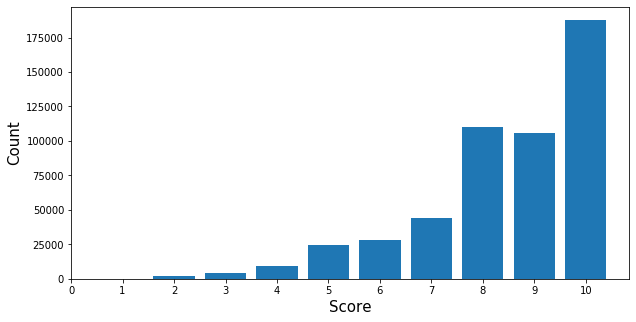

10    187744
8     110155
9     105722
7      44088
6      27800
5      24188
4       9436
3       4406
2       2199
Name: Reviewer_Score, dtype: int64

In [3]:
scores = hotel['Reviewer_Score'].value_counts()

plt.figure(figsize = (10,5))
plt.bar(scores.index, scores.values)
plt.xticks(range(0,11,1))
plt.xlabel('Score', size = 15)
plt.ylabel('Count', size = 15)
plt.show()

scores

It seems that the majority of the reviews are very positive! This is good for the hotels, but this introduces a problem. Say we classify reviews that score 8-10 as 'Good' and the rest as 'not good.' A simple program that said every review  was 'good' would already be $78\%$ right!

This means our model would have to correctly classify nearly all the data (better than $78\%$), which could prove challenging to achieve. To simplify the process, only reviews that score 9 or above will be considered 'good' since those only make up 57% of the data. 

<br>
<br>
<br>
<br>
To make the modeling easier, we can convert as many columns as we can to a numeric type. We can convert the following: 

1. Change the Review date to a datetime
2. Convert the days_since_reviews into an integer using a regular expression

and while I could attempt this operation: 

3. Use the `get dummies()` function to convert the Tags column into numeric types.

It would take up too much memory and take too long to run. I also belevie that the Tags are customizable to some degree, meaning there would be quite a lot of them to sift through, maybe too many. One could attempt PCA however I will leave that for later. 


the rest of the objects can't really be converted. 

In [4]:
#Converting the date
hotel['Review_Date'] = pd.to_datetime(hotel['Review_Date'], infer_datetime_format=True)

#Converting the days_since_reviews
hotel['days_since_review'] = hotel['days_since_review'].str.extract(r'(^\d)')

#Converting the tags to a list  for simplicity. 
hotel['Tags'] = hotel['Tags'].apply(literal_eval)

## Data Wrangling
Here is where some basic analysis is going to be performed. Since  my laptop lacks the power to handle such a large dataset, I will only  be using 10% of it. 

I will perform a few takss to get it ready for analysis: 

1. Convert the `Reviewer_Score` column into a binary column,if the  score is bigger or equal to 9, then  it  is 'good', else it is 'not good'


2. Drop the non-numeric columns like "Reviewer_Nationality" or "Hotel_Name"


3. Use a `CountVectorizer()` model to classify the reviews. 

In [5]:
#Making a small data frame
hotel_small = hotel.sample(frac = 0.1,  random_state = 1222).reset_index()

print(hotel_small.shape)
hotel_small.head()

(51574, 18)


,index,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,95441,20 28 Bolsover Street Westminster Borough Lond...,261,2016-08-25,8.1,Grange Fitzrovia Hotel,United Kingdom,Hot food at breakfast would make a good start...,34,1034,Hotel is well situated to central London lots...,29,5,8,"[ Solo traveler , Superior Double Room , Sta...",3,51.521759,-0.142538
1,388725,No 1 Seething Lane City of London London EC3N ...,623,2016-03-29,9.0,Apex City Of London Hotel,Ireland,Hotel bar prices very expensive,7,2750,The location was fab The hotel was spotless a...,15,9,10,"[ Leisure trip , Family with older children ,...",4,51.510462,-0.079550
2,123257,26 28 Trebovir Rd Kensington and Chelsea Londo...,328,2017-06-23,7.5,Mayflower Hotel Apartments,United Kingdom,Bedroom very small and basic breakfast very l...,10,2197,Good location,3,4,5,"[ Business trip , Couple , Small Double Room...",4,51.491668,-0.194747
3,453072,Slotermeerlaan 80 Geuzenveld Slotermeer 1064 H...,407,2017-01-03,7.3,Best Western Plus Hotel Blue Square,United Kingdom,The price with the exchange rate wasn t worth...,12,3161,Location Easy access to central and Amsterdam...,10,4,7,"[ Leisure trip , Travelers with friends , Ec...",2,52.378682,4.820783
4,460662,Staalmeesterslaan 410 Slotervaart 1057 PH Amst...,926,2016-11-07,8.2,Ramada Apollo Amsterdam Centre,United Kingdom,Nothing,2,5770,It was all a very good experience nice staff ...,13,1,10,"[ Leisure trip , Family with young children ,...",2,52.368130,4.844085


In [6]:
#1. Applying the condition (do NOT run cell twice, all user reviews will become 0)

hotel_small['Reviewer_Score'] = hotel_small['Reviewer_Score'].apply(lambda x: 1 if x >= 9 else 0)

In [7]:
#2. Dropping non-numeric columns

hotel_small.drop(['Hotel_Address',
                  'index',
                  'Hotel_Name',
                  'Reviewer_Nationality',
                  'Tags'],
                  axis = 1, inplace = True)
hotel_small.shape

(51574, 13)

In [8]:
#3. Use CountVectorizer() to analyze the positive and negative reviews. 

#Re-Arranging the columns to get target at the end
hotel_small = hotel_small[['Additional_Number_of_Scoring', 'Review_Date', 'Average_Score',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given',
       'days_since_review', 'lat', 'lng', 'Reviewer_Score']]

#Identifying the dependent and independent variable
X = hotel_small.iloc[:, 0:12]
y = hotel_small['Reviewer_Score']

#splitting them up into Training and testing sets: 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#Since I don't see any hyperparameters that need to be optimzed, I am assuming that we don't need a validation set. 

In [9]:
#Now, we will transfrom the reviews into something we can fit a model on using bagofwords. 
#Starting with the negative review:  

# 1. Instantiate: 
bagofwords = CountVectorizer()

# 2. Fit
bagofwords.fit(X_train['Negative_Review'])

# 3. Transform
X_train_negative = bagofwords.transform(X_train['Negative_Review'])
X_test_negative = bagofwords.transform(X_test['Negative_Review'])

In [10]:
#Moving on with the positive review:  

# 1. Instantiate: 
bagofwords = CountVectorizer()

# 2. Fit
bagofwords.fit(X_train['Positive_Review'])

# 3. Transform
X_train_positive = bagofwords.transform(X_train['Positive_Review'])
X_test_positive = bagofwords.transform(X_test['Positive_Review'])

In [11]:
#Now we have to combine this data. Unfortunatley I don't know how. 

The `min_df` parameter allows infrequently used words to be cut off. If you have a review in this dataset that is "very" speicifc to their experience, it would not help us too much in  the  grand  scheme of things. Using `min_df` we can eliminate this porblem entierly by ridding the dataset of these infrequently used phrases. 